In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import datetime, os

%load_ext tensorboard

np.random.seed(42)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
batch_size = 32
img_size = (240, 240)

# create a training dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Shoe Classification/train',
     shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='training', seed=42)

# create a validation dataset
valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/gdrive/MyDrive/Shoe Classification/train',
    shuffle=True, batch_size=batch_size, image_size=img_size,
    validation_split=0.2, subset='validation', seed=42
)
# create a test dataset
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'drive/MyDrive/shoes_classification/data/test/',
    shuffle=True, batch_size=batch_size, image_size=img_size
)

Found 778 files belonging to 3 classes.
Using 623 files for training.
Found 778 files belonging to 3 classes.
Using 155 files for validation.


In [ ]:
class_names = train_dataset.class_names
class_names

['Boots', 'Sandals', 'Slippers']

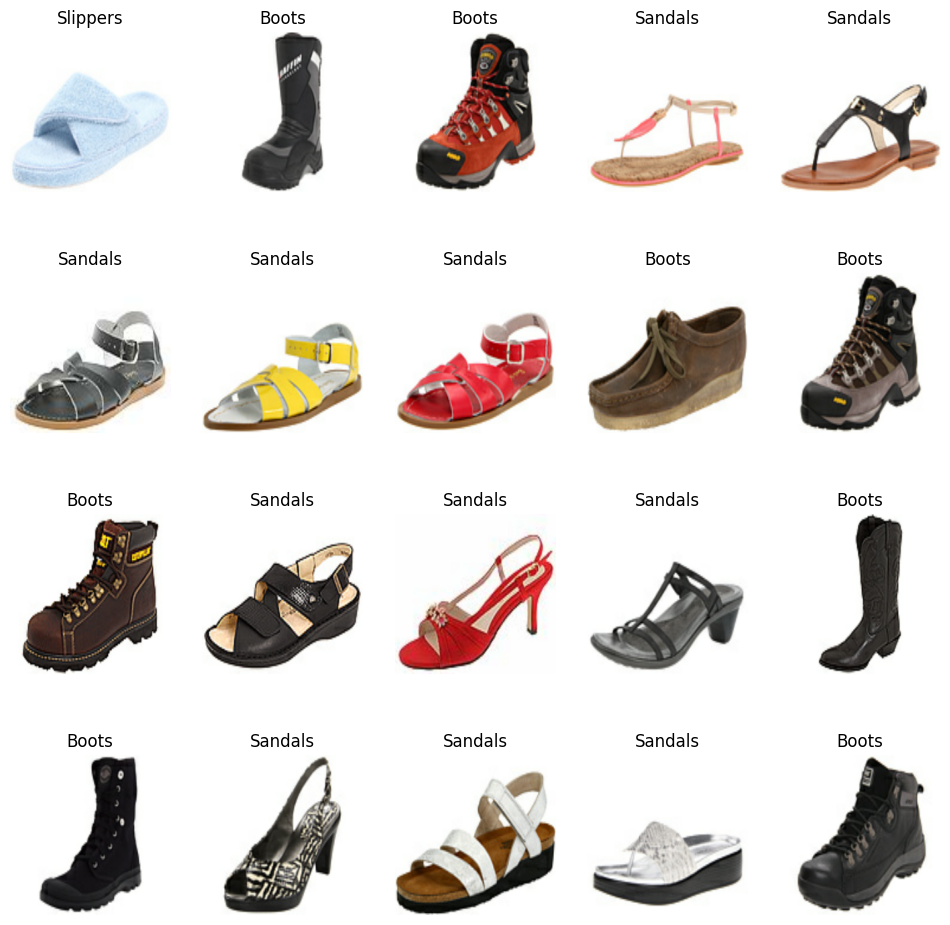

In [ ]:
plt.figure(figsize=(12, 12))
for images, labels in train_dataset.take(1):
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_dataset.class_names[labels[i]])
        plt.axis('off')

In [ ]:
# load a base model
base_model = keras.applications.xception.Xception(input_shape=(224, 224, 3),
                                                  weights='imagenet',
                                                  include_top=False)

In [ ]:
# create an input layer
input = keras.layers.Input(shape=(240, 240, 3))

# resize and preprocess input images
resized_input = keras.layers.Resizing(224, 224)(input)
preprocessed_input = keras.applications.xception.preprocess_input(resized_input)

# add data augmentation layers to reduce overfitting and make data more diverse
flip = keras.layers.RandomFlip('horizontal')(preprocessed_input)
rotation = keras.layers.RandomRotation(0.2)(flip)
zoom = keras.layers.RandomZoom(0.2)(rotation)

# run preprocessed images through the base model
base_model_output = base_model(zoom)

# add a GlobalAveragePooling layer and a dropout layer to reduce overfitting
avg = keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = keras.layers.Dropout(0.2)(avg)

# add a fully connected layer with 3 nodes since the dataset has 3 classes
output = keras.layers.Dense(3, activation='softmax')(dropout)

# create a model
model = keras.Model(inputs=input, outputs=output)

In [ ]:
# create a tensorboard callback to track accuracy and loss for different epochs
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=50, validation_data=valid_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/50
20/20 [==============================] - 250s 12s/step - loss: 1.0798 - accuracy: 0.4222 - val_loss: 0.9946 - val_accuracy: 0.4839
Epoch 2/50
20/20 [==============================] - 198s 10s/step - loss: 0.9585 - accuracy: 0.5120 - val_loss: 0.8682 - val_accuracy: 0.6774
Epoch 3/50
20/20 [==============================] - 189s 10s/step - loss: 0.8624 - accuracy: 0.6148 - val_loss: 0.7661 - val_accuracy: 0.7806
Epoch 4/50
20/20 [==============================] - 185s 9s/step - loss: 0.7810 - accuracy: 0.6982 - val_loss: 0.6870 - val_accuracy: 0.8000
Epoch 5/50
20/20 [==============================] - 191s 10s/step - loss: 0.7088 - accuracy: 0.7512 - val_loss: 0.6188 - val_accuracy: 0.8452
Epoch 6/50
20/20 [==============================] - 192s 10s/step - loss: 0.6680 - accuracy: 0.7705 - val_loss: 0.5648 - val_accuracy: 0.8516
Epoch 7/50
20/20 [==============================] - 191s 10s/step - loss: 0.6136 - accuracy: 0.8186 - val_loss: 0.5159 - val_accuracy: 0.8516
Epoch 8

In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>